In [ ]:
## **4. Methodology**

### **4.1 Overview of Experimental Procedure**

This section outlines the methodology used to evaluate three progressively fine-tuned versions of the **MobileViT-Small** model for a 7-class image classification task. The workflow includes dataset preparation, model setup with varied transfer learning strategies, consistent evaluation using fixed splits, and systematic artifact management for reproducibility.

---

### **4.2 Dataset Preparation**

A total of **4900 images** spanning **7 categories** were used for experimentation. These images were derived from **700 original samples**, each augmented several times. To ensure that augmented variants of the same original image did not span multiple splits, a **groupwise splitting** technique was employed.

Image filenames were parsed to extract a base identifier, and grouping was performed accordingly. The dataset was then split into:
- **Training Set**: 3462 samples (~70%)
- **Validation Set**: 709 samples (~15%)
- **Test Set**: 729 samples (~15%)

All images were resized to **224×224 pixels** and normalized using **ImageNet statistics** for compatibility with pretrained vision transformer backbones.

---

### **4.3 Model Architecture and Training Configurations**

Three different training configurations were applied to the **MobileViT-Small (`mobilevit_s`)** model, implemented using the `timm` and `torchvision` libraries. Each version reflects a different strategy in terms of layer freezing, classification head modification, learning rate scheduling, and dropout regularization.

#### **4.3.1 Version 1 (V1)**
- **Pretrained Weights**: Yes (ImageNet-1k)
- **Frozen Layers**:
  - Stem (initial convolutional layers)
  - First two `MobileViT` stages
- **Classifier Head**: Original MobileViT head
- **Optimizer**: AdamW (lr = 1e-4, weight decay = 1e-5)
- **Scheduler**: StepLR (step size = 5, gamma = 0.1)
- **Dropout**: Not used
- **Epochs**: 15

#### **4.3.2 Version 2 (V2)**
- **Pretrained Weights**: Custom weights from V1 (excluding classifier head)
- **Frozen Layers**:
  - Stem + all MobileViT stages except the final one
- **Classifier Head**: Replaced with custom head  
  (`AvgPool → Flatten → Linear(512) → ReLU → Dropout(0.5) → Linear(7)`)
- **Optimizer**: AdamW with layer-wise learning rate decay  
  - Stage 0: 1e-5  
  - Stages 1–3: 3e-5  
  - Head: 5e-5
- **Scheduler**: CosineAnnealingLR (T_max = 15)
- **Dropout**: 0.5
- **Epochs**: 15

#### **4.3.3 Version 3 (V3)**
- **Pretrained Weights**: Custom weights from V2 (excluding classifier head)
- **Frozen Layers**: None (full model unfrozen)
- **Classifier Head**: Same structure as V2 with increased dropout (0.5)
- **Optimizer**: Same as V2 (layer-wise LRs)
- **Scheduler**: CosineAnnealingLR (T_max = 15)
- **Dropout**: 0.5
- **Epochs**: 30
- **Early Stopping**: Patience of 30 epochs

---

### **4.4 Evaluation Protocol**

All model versions were evaluated on the **same test and validation sets** for consistent comparison. The key performance metrics used were:
- **Overall Accuracy**
- **Validation Loss**
- **Confusion Matrix**
- **Train/Validation Accuracy and Loss Curves**

Models were evaluated using both the `val_loader` and `test_loader`, and performance curves were generated using a unified visualization pipeline.

---

### **4.5 Model Saving and Artifact Management**

For reproducibility and traceability, the following artifacts were saved for each model version:
- Best-performing model weights (`.pth`)
- Training history (accuracy/loss)
- Evaluation results on validation and test sets
- Diagnostic plots (curves, confusion matrix)

Files were structured into version-specific directories under:
```
MobileViT_Small/
    └── V1/
    └── V2/
    └── V3/
```

In [ ]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import sys
import os
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
# the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Utils.utils import evaluate_model, plotting, save_model_artifacts, handle_dataset

In [4]:
train_loader, val_loader, test_loader, class_names = handle_dataset(x=224,y=224,batch_size=32)

Number of classes: 7
Training samples: 3462
Validation samples: 709
Test samples: 729


In [5]:
import timm
import torch

num_classes = 7  # Define the number of classes for classification.

# The MobileViT-Small model is loaded from timm with pre-trained weights.
model1 = timm.create_model('mobilevit_s', pretrained=True, num_classes=num_classes)

# The early convolutional layers (initial feature extractor) are frozen.
for param in model1.stem.parameters():
    param.requires_grad = False  # The early CNN layers are frozen.

# The first two MobileViT stages (which contain early transformer layers) are frozen.
for i in range(2):  # Access each stage explicitly
    for param in model1.stages[i].parameters():  
        param.requires_grad = False  # The first two stages are frozen.

# The device (CPU or GPU) is determined.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The model is moved to the selected device.
model1.to(device)

print(f"Model loaded, early layers frozen, and moved to {device}")

Model loaded, early layers frozen, and moved to cpu


In [7]:
# The loss function is defined.
criterion = nn.CrossEntropyLoss()

# The AdamW optimizer is used.
optimizer = optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-5)

# A learning rate scheduler is added to adjust the learning rate over time.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15):
    # A dictionary is created to store training history.
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        # The model is set to training mode.
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop is started.
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # The model is set to evaluation mode.
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        # Validation loop is started.
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # The learning rate scheduler is updated.
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

    return history

# The model is trained and history is obtained.
history1 = train(model1, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15)

Epoch 1/15: 100%|█████████████████████████████| 109/109 [11:48<00:00,  6.50s/it]


Epoch 1/15: Train Loss: 1.4642, Train Acc: 64.96% | Val Loss: 0.9611, Val Acc: 73.20%



Epoch 2/15: 100%|█████████████████████████████| 109/109 [14:13<00:00,  7.83s/it]


Epoch 2/15: Train Loss: 0.5948, Train Acc: 86.40% | Val Loss: 0.4427, Val Acc: 86.32%



Epoch 3/15: 100%|█████████████████████████████| 109/109 [14:19<00:00,  7.89s/it]


Epoch 3/15: Train Loss: 0.2899, Train Acc: 93.18% | Val Loss: 0.3066, Val Acc: 90.69%



Epoch 4/15: 100%|█████████████████████████████| 109/109 [14:24<00:00,  7.93s/it]


Epoch 4/15: Train Loss: 0.1994, Train Acc: 94.77% | Val Loss: 0.2303, Val Acc: 92.67%



Epoch 5/15: 100%|█████████████████████████████| 109/109 [14:42<00:00,  8.09s/it]


Epoch 5/15: Train Loss: 0.1247, Train Acc: 96.91% | Val Loss: 0.2026, Val Acc: 93.37%



Epoch 6/15: 100%|█████████████████████████████| 109/109 [13:18<00:00,  7.32s/it]


Epoch 6/15: Train Loss: 0.0934, Train Acc: 98.18% | Val Loss: 0.1745, Val Acc: 94.36%



Epoch 7/15: 100%|█████████████████████████████| 109/109 [12:48<00:00,  7.05s/it]


Epoch 7/15: Train Loss: 0.0705, Train Acc: 98.67% | Val Loss: 0.1784, Val Acc: 94.78%



Epoch 8/15: 100%|█████████████████████████████| 109/109 [07:59<00:00,  4.40s/it]


Epoch 8/15: Train Loss: 0.0759, Train Acc: 98.50% | Val Loss: 0.1835, Val Acc: 95.06%



Epoch 9/15: 100%|█████████████████████████████| 109/109 [08:09<00:00,  4.49s/it]


Epoch 9/15: Train Loss: 0.0708, Train Acc: 98.50% | Val Loss: 0.1822, Val Acc: 94.78%



Epoch 10/15: 100%|████████████████████████████| 109/109 [08:02<00:00,  4.42s/it]


Epoch 10/15: Train Loss: 0.0661, Train Acc: 98.67% | Val Loss: 0.1776, Val Acc: 94.22%



Epoch 11/15: 100%|████████████████████████████| 109/109 [08:08<00:00,  4.48s/it]


Epoch 11/15: Train Loss: 0.0551, Train Acc: 99.10% | Val Loss: 0.1850, Val Acc: 94.78%



Epoch 12/15: 100%|████████████████████████████| 109/109 [08:17<00:00,  4.56s/it]


Epoch 12/15: Train Loss: 0.0578, Train Acc: 99.08% | Val Loss: 0.1829, Val Acc: 94.50%



Epoch 13/15: 100%|████████████████████████████| 109/109 [08:22<00:00,  4.61s/it]


Epoch 13/15: Train Loss: 0.0550, Train Acc: 98.99% | Val Loss: 0.1854, Val Acc: 94.64%



Epoch 14/15: 100%|████████████████████████████| 109/109 [08:19<00:00,  4.58s/it]


Epoch 14/15: Train Loss: 0.0496, Train Acc: 99.16% | Val Loss: 0.1792, Val Acc: 94.92%



Epoch 15/15: 100%|████████████████████████████| 109/109 [08:16<00:00,  4.55s/it]


Epoch 15/15: Train Loss: 0.0611, Train Acc: 98.99% | Val Loss: 0.1734, Val Acc: 94.78%



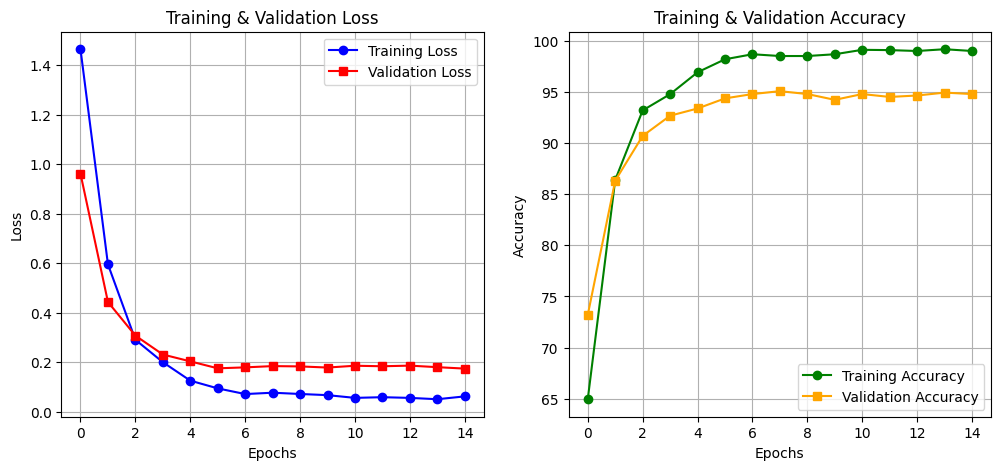

In [10]:
plottting1=plotting(history1)


Evaluating model with Validation loader.

Overall Accuracy: 94.78%
Overall Error Rate: 5.22%
F1-Score (Macro-Averaged): 94.89%
F1-Score (Weighted): 94.77%
Matthews Correlation Coefficient (MCC): 93.91%
Cohen’s Kappa Score: 93.90%
Top-1 Accuracy (%): 94.78%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.070708 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          95.37       92.79         94.06            99.16
 BRRI_28          91.75       98.89         95.19            98.71
 BRRI_29          95.24       90.09         92.59            99.16
 BRRI_34          93.52       94.39         93.95            98.84
 BRRI_50          97.56       97.56         97.56            99.68
 BRRI_74          96.26       96.26         96.26            99.34
    BR_5          94.12       95.05         94.58            99.01

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BRR

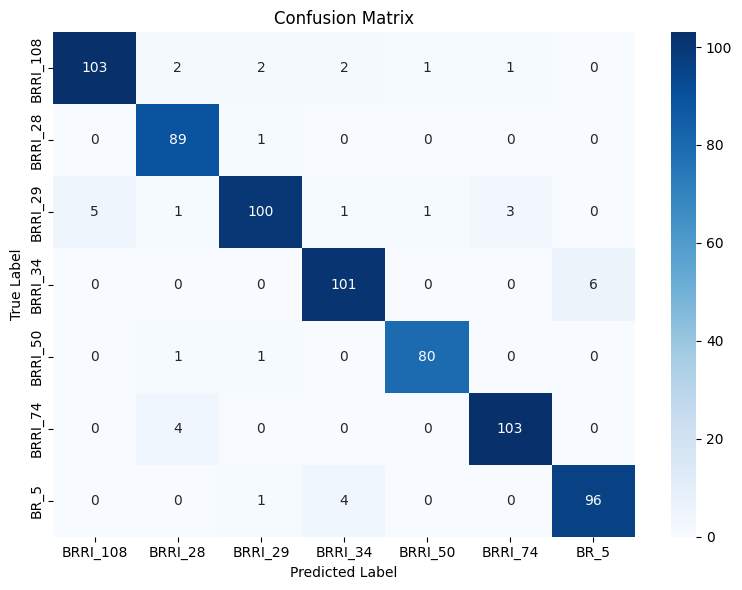

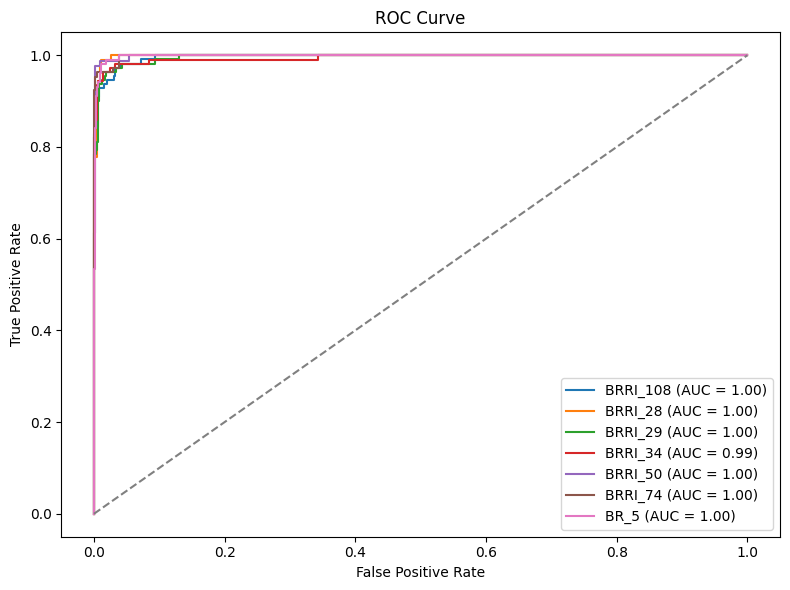

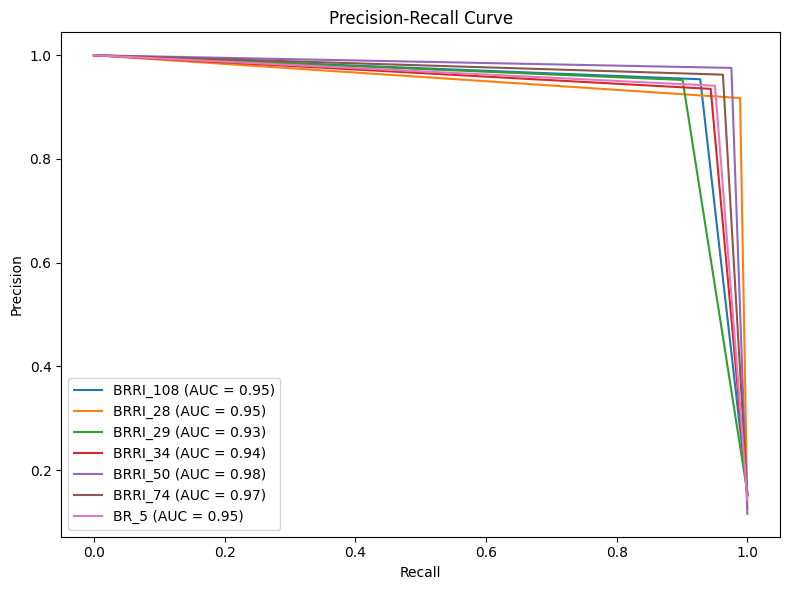

In [12]:
metrics1=evaluate_model(model1, val_loader, class_names, loader_name="Validation")


Evaluating model with Testing loader.

Overall Accuracy: 94.92%
Overall Error Rate: 5.08%
F1-Score (Macro-Averaged): 94.92%
F1-Score (Weighted): 94.93%
Matthews Correlation Coefficient (MCC): 94.07%
Cohen’s Kappa Score: 94.07%
Top-1 Accuracy (%): 94.92%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.144175 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          95.65       94.02         94.83            99.18
 BRRI_28          91.94       95.00         93.44            98.36
 BRRI_29          92.39       92.39         92.39            98.90
 BRRI_34          95.33       93.58         94.44            99.19
 BRRI_50          99.07       98.15         98.60            99.84
 BRRI_74          95.56       94.51         95.03            99.37
    BR_5          94.68       96.74         95.70            99.22

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_2

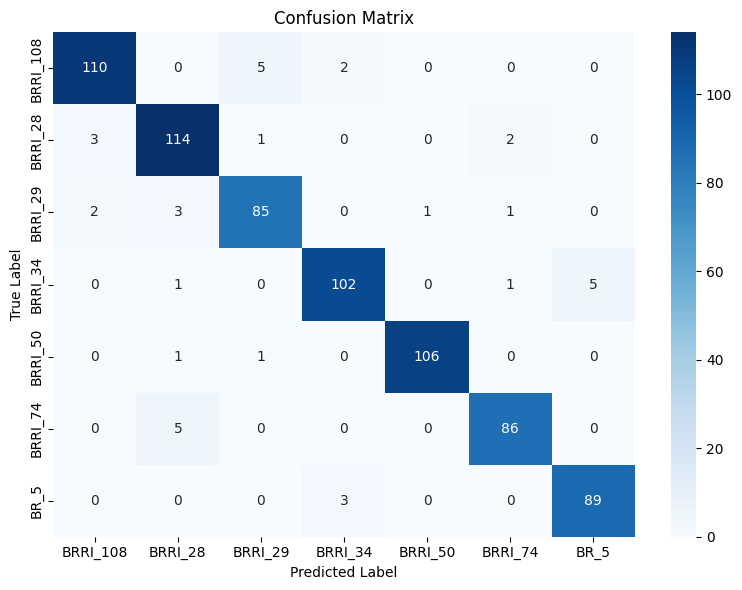

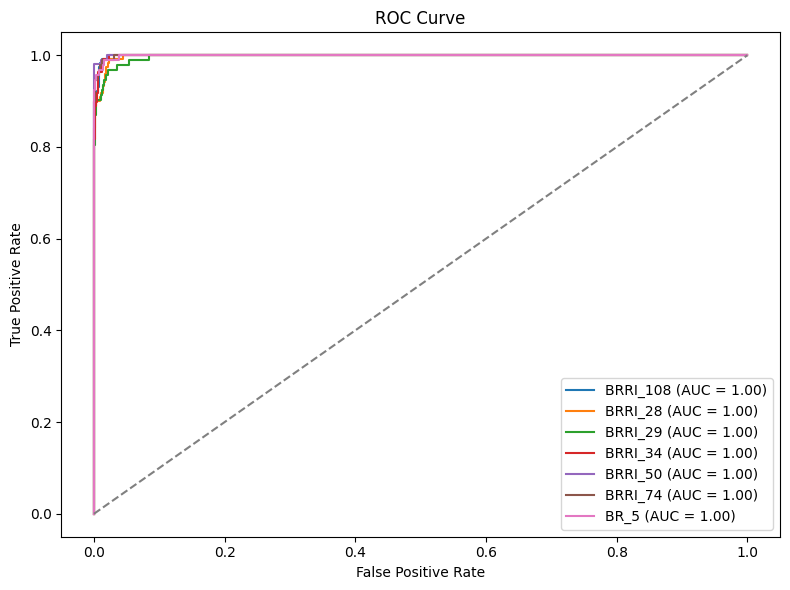

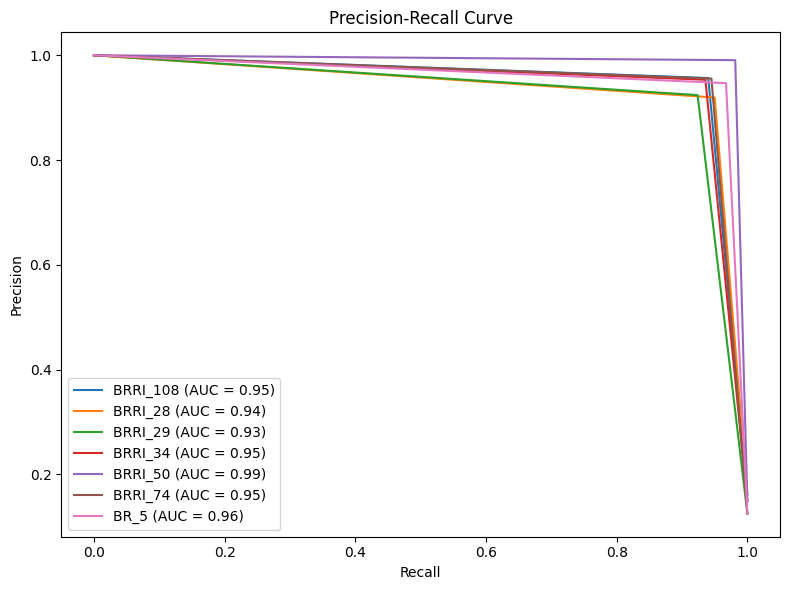

In [27]:
metrics1=evaluate_model(model1, test_loader, class_names, loader_name="Testing")

In [14]:
save_model_artifacts(model=model1,history=history1,metrics=metrics1,model_name="mobileViT_small",version="1")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/mobileViT_small_training_metrics_1.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/mobileViT_small/mobileViT_small_1.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/mobileViT_small_evaluation_metrics_1.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/mobileViT_small_class_wise_metrics_1.csv


# Version 2

In [34]:
import timm
import torch
import torch.nn as nn

# The device is selected based on availability.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The MobileViT-Small model is loaded (pretrained=False since custom weights will be used).
model2 = timm.create_model("mobilevit_s", pretrained=False, num_classes=num_classes)

# The trained model weights are loaded.
model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/mobileViT_small/mobileViT_small_1.pth"
model2.load_state_dict(torch.load(model_path, map_location=device))
model2.to(device)

# The correct number of input features is extracted dynamically.
in_features = model2.head.fc.in_features if hasattr(model.head, 'fc') else model2.head.in_features

# The classification head is redefined for fine-tuning.
model.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),  # Ensures spatial reduction to 1x1
    nn.Flatten(),  # Flattens (batch_size, channels, 1, 1) to (batch_size, channels)
    nn.Linear(in_features, 512),  # New fully connected layer
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Dropout added to prevent overfitting
    nn.Linear(512, num_classes)  # Final classification layer
)
# The early convolutional layers (first stage) are frozen.
for param in model2.stages[0].parameters():  
    param.requires_grad = False  

# The first few MobileViT blocks are kept frozen, while deeper blocks are fine-tuned.
for i in range(len(model2.stages) - 1):  # Freeze all but the last stage
    for param in model2.stages[i].parameters():
        param.requires_grad = False

# The classification head remains trainable.
for param in model2.head.parameters():  
    param.requires_grad = True  

# A confirmation message is printed.
print(f"Model loaded, deeper layers have been unfrozen for fine-tuning and moved to {device}")

Model loaded, deeper layers have been unfrozen for fine-tuning and moved to cpu


In [35]:
import torch.nn as nn
import torch.optim as optim

# The loss function is defined.
criterion = nn.CrossEntropyLoss()

# Optimizer with layer-wise learning rate decay (recommended for MobileViT fine-tuning)
optimizer = optim.AdamW([
    {'params': model.stages[0].parameters(), 'lr': 1e-5},
    {'params': [param for stage in model.stages[1:] for param in stage.parameters()], 'lr': 3e-5},
    {'params': model.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)

# Learning rate scheduler (Cosine Annealing for smooth LR adjustment)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

print("Loss function, optimizer, and learning rate scheduler have been defined.")

Loss function, optimizer, and learning rate scheduler have been defined.


In [36]:
import torch
from tqdm import tqdm

def train2(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience):
    # A dictionary is created to store training history.
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Early stopping parameters are defined.
    best_val_loss = float("inf")  
    best_val_acc = 0.0  # Added for optional accuracy-based saving
    counter = 0  

    # Training loop begins.
    for epoch in range(epochs):
        # The model is set to training mode.
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # The training loop is started.
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Gradients are reset.
            outputs = model(images)  # Forward pass.
            loss = criterion(outputs, labels)  # Loss is computed.
            loss.backward()  # Backward pass.
            optimizer.step()  # Parameters are updated.

            # Training metrics are accumulated.
            running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)  # More explicit than .max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Training loss and accuracy are calculated.
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # The model is set to evaluation mode.
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        # The validation loop is started.
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Validation loss and accuracy are calculated.
        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

        # Save the best model based on validation loss or accuracy
        if val_loss < best_val_loss or val_acc > best_val_acc:
            best_val_loss = val_loss
            best_val_acc = val_acc
            counter = 0  
            torch.save(model.state_dict(), "Mobile_best_model.pth")  
            print("Model improved and saved.")
        else:
            counter += 1  
            print(f"Early Stopping Counter: {counter}/{patience}")

            if counter >= patience:
                print("Early stopping triggered. Training has been stopped.")
                break  

        # Learning rate scheduler update
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)  # If using ReduceLROnPlateau, pass val_loss
        else:
            scheduler.step()  # StepLR or CosineAnnealingLR do not need val_loss

    return history

# Training the model with early stopping and scheduler handling.
history2 = train2(model2, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15, patience=15)

Epoch 1/15: 100%|█████████████████████████████| 109/109 [41:27<00:00, 22.82s/it]


Epoch 1/15: Train Loss: 0.0689, Train Acc: 98.76% | Val Loss: 0.1879, Val Acc: 94.08%

Model improved and saved.


Epoch 2/15: 100%|█████████████████████████████| 109/109 [41:40<00:00, 22.94s/it]


Epoch 2/15: Train Loss: 0.0531, Train Acc: 99.10% | Val Loss: 0.1635, Val Acc: 95.35%

Model improved and saved.


Epoch 3/15: 100%|█████████████████████████████| 109/109 [27:01<00:00, 14.87s/it]


Epoch 3/15: Train Loss: 0.0592, Train Acc: 98.84% | Val Loss: 0.1684, Val Acc: 94.92%

Early Stopping Counter: 1/15


Epoch 4/15: 100%|█████████████████████████████| 109/109 [28:30<00:00, 15.70s/it]


Epoch 4/15: Train Loss: 0.0562, Train Acc: 99.16% | Val Loss: 0.1782, Val Acc: 95.20%

Early Stopping Counter: 2/15


Epoch 5/15: 100%|█████████████████████████████| 109/109 [31:00<00:00, 17.07s/it]


Epoch 5/15: Train Loss: 0.0617, Train Acc: 98.84% | Val Loss: 0.1800, Val Acc: 94.64%

Early Stopping Counter: 3/15


Epoch 6/15: 100%|█████████████████████████████| 109/109 [17:58<00:00,  9.90s/it]


Epoch 6/15: Train Loss: 0.0605, Train Acc: 99.13% | Val Loss: 0.1799, Val Acc: 94.36%

Early Stopping Counter: 4/15


Epoch 7/15: 100%|█████████████████████████████| 109/109 [13:04<00:00,  7.20s/it]


Epoch 7/15: Train Loss: 0.0640, Train Acc: 99.05% | Val Loss: 0.1826, Val Acc: 94.64%

Early Stopping Counter: 5/15


Epoch 8/15: 100%|█████████████████████████████| 109/109 [13:23<00:00,  7.37s/it]


Epoch 8/15: Train Loss: 0.0568, Train Acc: 98.96% | Val Loss: 0.1731, Val Acc: 94.92%

Early Stopping Counter: 6/15


Epoch 9/15: 100%|█████████████████████████████| 109/109 [13:57<00:00,  7.68s/it]


Epoch 9/15: Train Loss: 0.0569, Train Acc: 99.05% | Val Loss: 0.1704, Val Acc: 94.78%

Early Stopping Counter: 7/15


Epoch 10/15: 100%|████████████████████████████| 109/109 [15:03<00:00,  8.29s/it]


Epoch 10/15: Train Loss: 0.0554, Train Acc: 98.99% | Val Loss: 0.1808, Val Acc: 94.64%

Early Stopping Counter: 8/15


Epoch 11/15: 100%|████████████████████████████| 109/109 [14:57<00:00,  8.23s/it]


Epoch 11/15: Train Loss: 0.0709, Train Acc: 98.70% | Val Loss: 0.1719, Val Acc: 95.35%

Early Stopping Counter: 9/15


Epoch 12/15: 100%|████████████████████████████| 109/109 [12:37<00:00,  6.95s/it]


Epoch 12/15: Train Loss: 0.0486, Train Acc: 99.22% | Val Loss: 0.1702, Val Acc: 94.64%

Early Stopping Counter: 10/15


Epoch 13/15: 100%|████████████████████████████| 109/109 [15:25<00:00,  8.49s/it]


Epoch 13/15: Train Loss: 0.0534, Train Acc: 99.10% | Val Loss: 0.1731, Val Acc: 94.78%

Early Stopping Counter: 11/15


Epoch 14/15: 100%|████████████████████████████| 109/109 [16:39<00:00,  9.17s/it]


Epoch 14/15: Train Loss: 0.0624, Train Acc: 98.76% | Val Loss: 0.1761, Val Acc: 94.78%

Early Stopping Counter: 12/15


Epoch 15/15: 100%|████████████████████████████| 109/109 [12:54<00:00,  7.10s/it]


Epoch 15/15: Train Loss: 0.0552, Train Acc: 98.90% | Val Loss: 0.1790, Val Acc: 94.64%

Early Stopping Counter: 13/15


In [37]:
def merge_histories(history1, history2):
    merged = {}
    for key in history1:
        merged[key] = history1[key] + history2.get(key, [])
    return merged
full_history2 = merge_histories(history1, history2)

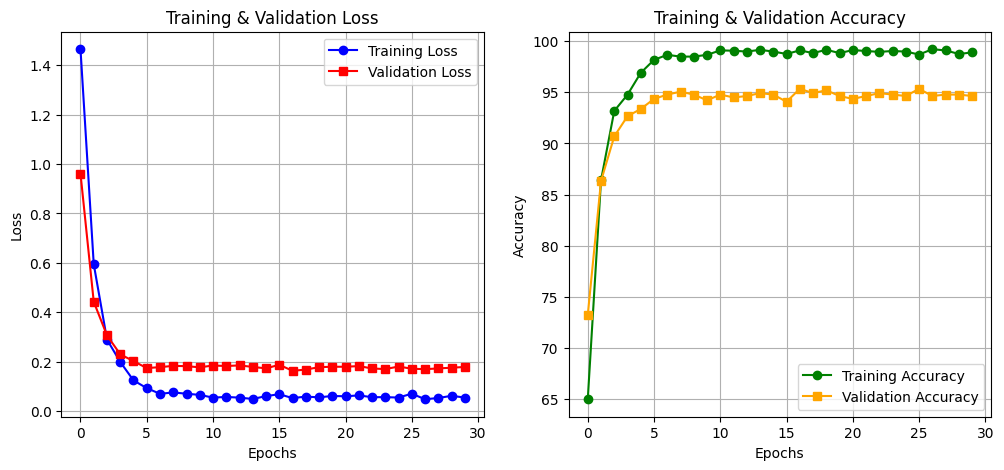

In [38]:
plotting(full_history2)


Evaluating model with Validation loader.

Overall Accuracy: 94.64%
Overall Error Rate: 5.36%
F1-Score (Macro-Averaged): 94.72%
F1-Score (Weighted): 94.62%
Matthews Correlation Coefficient (MCC): 93.75%
Cohen’s Kappa Score: 93.74%
Top-1 Accuracy (%): 94.64%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.072086 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          95.33       91.89         93.58            99.16
 BRRI_28          93.62       97.78         95.65            99.03
 BRRI_29          95.24       90.09         92.59            99.16
 BRRI_34          93.52       94.39         93.95            98.84
 BRRI_50          94.19       98.78         96.43            99.20
 BRRI_74          96.26       96.26         96.26            99.34
    BR_5          94.12       95.05         94.58            99.01

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BRR

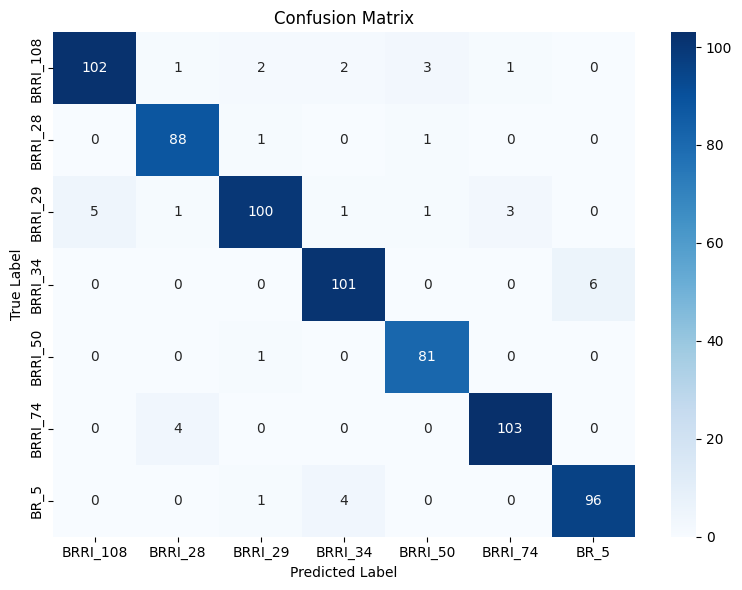

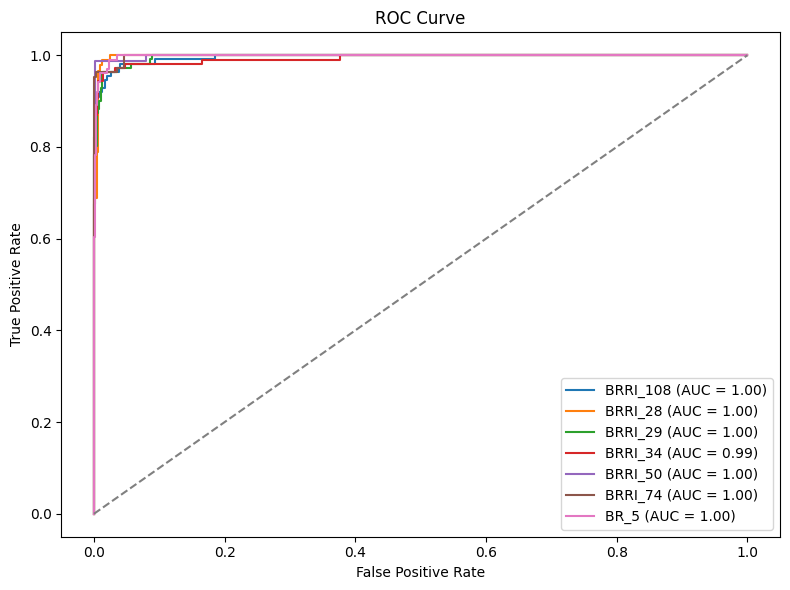

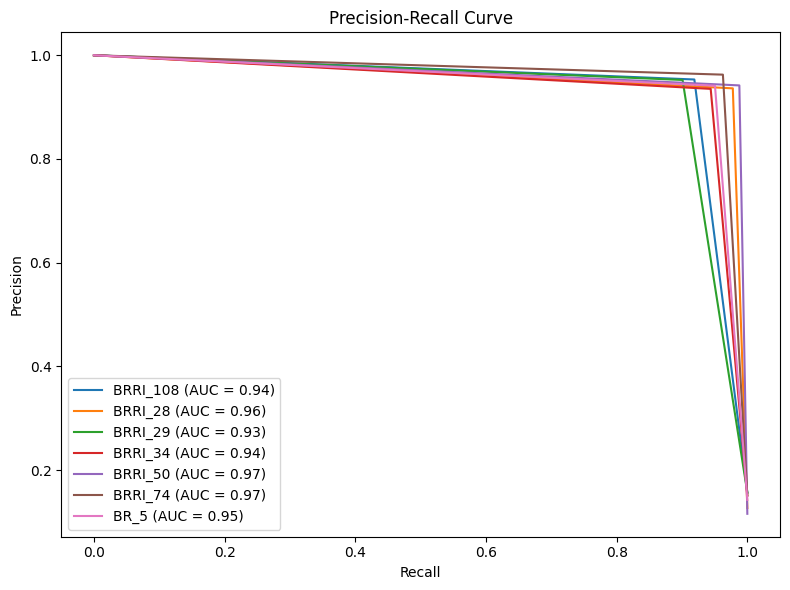

In [41]:
metrics2=evaluate_model(model2, val_loader, class_names, loader_name="Validation")


Evaluating model with Testing loader.

Overall Accuracy: 94.92%
Overall Error Rate: 5.08%
F1-Score (Macro-Averaged): 94.91%
F1-Score (Weighted): 94.93%
Matthews Correlation Coefficient (MCC): 94.07%
Cohen’s Kappa Score: 94.07%
Top-1 Accuracy (%): 94.92%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.086314 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          97.32       93.16         95.20            99.51
 BRRI_28          92.68       95.00         93.83            98.52
 BRRI_29          91.49       93.48         92.47            98.74
 BRRI_34          96.19       92.66         94.39            99.35
 BRRI_50          97.25       98.15         97.70            99.52
 BRRI_74          95.60       95.60         95.60            99.37
    BR_5          93.68       96.74         95.19            99.06

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_2

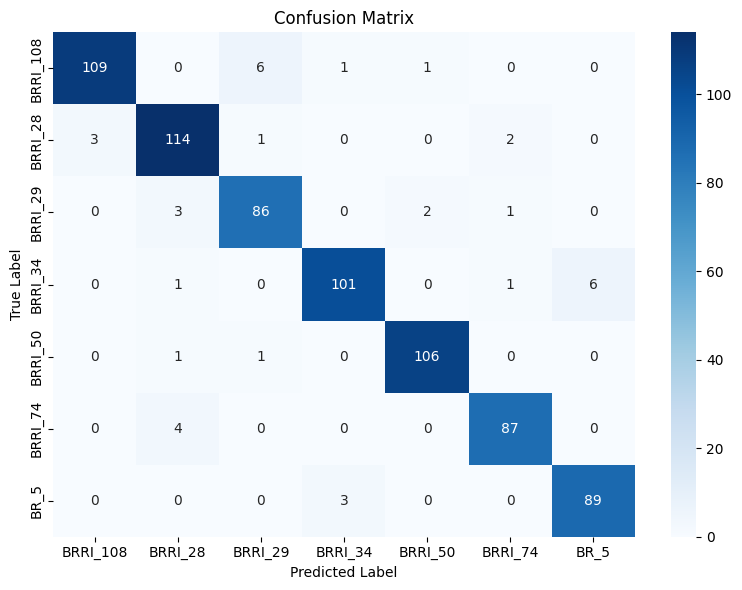

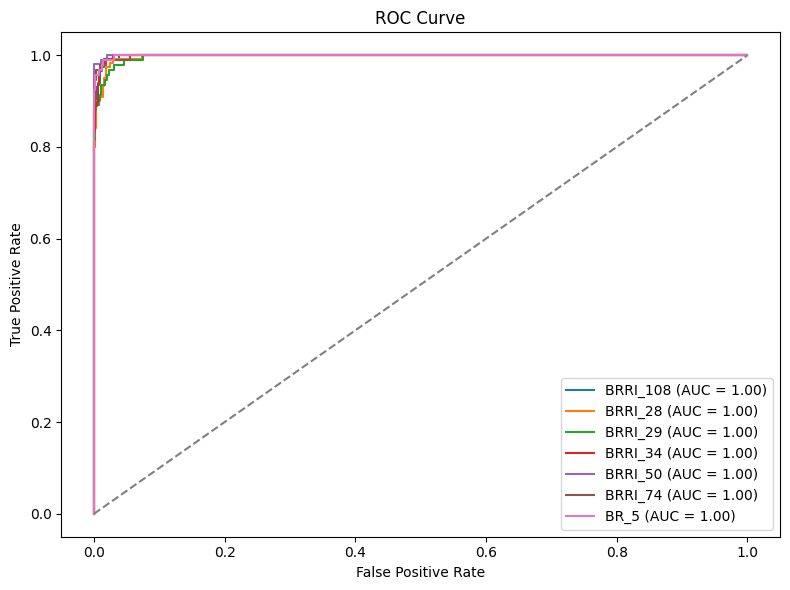

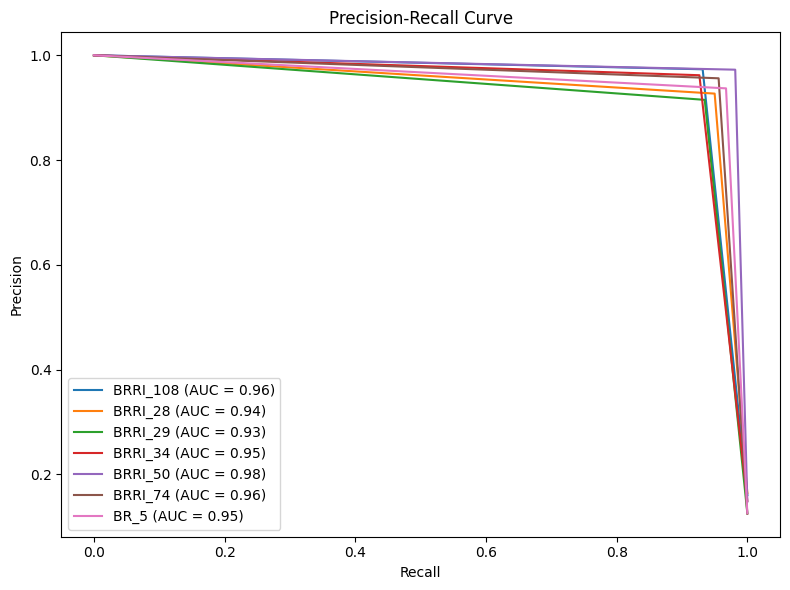

In [42]:
metrics2=evaluate_model(model2, test_loader, class_names, loader_name="Testing")

In [43]:
save_model_artifacts(model=model2,history=history2,metrics=metrics2,model_name="mobileViT_small",version="2")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/mobileViT_small_training_metrics_2.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/mobileViT_small/mobileViT_small_2.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/mobileViT_small_evaluation_metrics_2.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/mobileViT_small_class_wise_metrics_2.csv


In [47]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress tracking

# The device is selected based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of output classes (must match dataset)
num_classes = 7  

# The previously trained MobileViT-Small model is loaded
model3 = timm.create_model("mobilevit_s", pretrained=False, num_classes=num_classes)

# Extract input features from original classification head
in_features = model3.head.in_features  

# Modify classification head (Dropout increased to 50%)
model3.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),  # Ensure spatial reduction to 1x1
    nn.Flatten(),  # Convert [batch, channels, 1, 1] to [batch, channels]
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)  # Fully connected output layer
)

# Load trained model weights, excluding mismatching classification head weights
model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/mobileViT_small/mobileViT_small_2.pth"
state_dict = torch.load(model_path, map_location=device)
state_dict = {k: v for k, v in state_dict.items() if "head" not in k}  # Ignore mismatching classification head
model3.load_state_dict(state_dict, strict=False)

# Move model to device
model3.to(device)

# Unfreeze all layers
for param in model3.parameters():  
    param.requires_grad = True

print("The model has been loaded successfully with updated dropout (50%). All layers are unfrozen. Training is resuming for 15 extra epochs.")

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer with Layer-wise Learning Rate Decay
optimizer = optim.AdamW([
    {'params': model3.stages[0].parameters(), 'lr': 1e-5},
    {'params': model3.stages[1:].parameters(), 'lr': 3e-5},
    {'params': model3.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Function to continue training

def train_model3(model, train_loader, val_loader, criterion, optimizer, scheduler, extra_epochs=15, patience=6):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    counter = 0  

    for epoch in range(extra_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{extra_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)  
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{extra_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss
            }, "MobileViT_V3_best_model.pth")
            print("The model has improved and has been saved.")
        else:
            counter += 1  
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print("Early stopping has been triggered. Training has been stopped.")
                break  

    return history

# Continue training for extra epochs
history3 = train_model3(model3, train_loader, val_loader, criterion, optimizer, scheduler, extra_epochs=30, patience=30)

The model has been loaded successfully with updated dropout (50%). All layers are unfrozen. Training is resuming for 15 extra epochs.


Epoch 1/30: 100%|█████████████████████████████| 109/109 [45:50<00:00, 25.23s/it]


Epoch 1/30: Train Loss: 1.3930, Train Acc: 66.38% | Val Loss: 0.9064, Val Acc: 94.64%

The model has improved and has been saved.


Epoch 2/30: 100%|█████████████████████████████| 109/109 [51:07<00:00, 28.14s/it]


Epoch 2/30: Train Loss: 0.6732, Train Acc: 97.80% | Val Loss: 0.5128, Val Acc: 94.78%

The model has improved and has been saved.


Epoch 3/30: 100%|█████████████████████████████| 109/109 [58:04<00:00, 31.97s/it]


Epoch 3/30: Train Loss: 0.4053, Train Acc: 98.18% | Val Loss: 0.3606, Val Acc: 95.20%

The model has improved and has been saved.


Epoch 4/30: 100%|█████████████████████████████| 109/109 [54:25<00:00, 29.96s/it]


Epoch 4/30: Train Loss: 0.2685, Train Acc: 98.73% | Val Loss: 0.2816, Val Acc: 95.20%

The model has improved and has been saved.


Epoch 5/30: 100%|█████████████████████████████| 109/109 [51:54<00:00, 28.58s/it]


Epoch 5/30: Train Loss: 0.2064, Train Acc: 98.82% | Val Loss: 0.2560, Val Acc: 93.94%

The model has improved and has been saved.


Epoch 6/30: 100%|█████████████████████████████| 109/109 [51:58<00:00, 28.61s/it]


Epoch 6/30: Train Loss: 0.1663, Train Acc: 98.99% | Val Loss: 0.2134, Val Acc: 95.49%

The model has improved and has been saved.


Epoch 7/30: 100%|█████████████████████████████| 109/109 [49:25<00:00, 27.21s/it]


Epoch 7/30: Train Loss: 0.1288, Train Acc: 99.39% | Val Loss: 0.2108, Val Acc: 94.64%

The model has improved and has been saved.


Epoch 8/30: 100%|█████████████████████████████| 109/109 [49:28<00:00, 27.24s/it]


Epoch 8/30: Train Loss: 0.1123, Train Acc: 99.34% | Val Loss: 0.1911, Val Acc: 95.06%

The model has improved and has been saved.


Epoch 9/30: 100%|█████████████████████████████| 109/109 [37:42<00:00, 20.76s/it]


Epoch 9/30: Train Loss: 0.1027, Train Acc: 99.48% | Val Loss: 0.1806, Val Acc: 95.63%

The model has improved and has been saved.


Epoch 10/30: 100%|████████████████████████████| 109/109 [33:02<00:00, 18.19s/it]


Epoch 10/30: Train Loss: 0.0947, Train Acc: 99.28% | Val Loss: 0.1940, Val Acc: 95.06%

Early stopping counter: 1/30


Epoch 11/30: 100%|████████████████████████████| 109/109 [33:41<00:00, 18.54s/it]


Epoch 11/30: Train Loss: 0.0828, Train Acc: 99.65% | Val Loss: 0.1823, Val Acc: 95.06%

Early stopping counter: 2/30


Epoch 12/30: 100%|████████████████████████████| 109/109 [32:28<00:00, 17.87s/it]


Epoch 12/30: Train Loss: 0.0812, Train Acc: 99.60% | Val Loss: 0.2061, Val Acc: 94.64%

Early stopping counter: 3/30


Epoch 13/30: 100%|████████████████████████████| 109/109 [43:01<00:00, 23.69s/it]


Epoch 13/30: Train Loss: 0.0851, Train Acc: 99.39% | Val Loss: 0.1987, Val Acc: 94.92%

Early stopping counter: 4/30


Epoch 14/30: 100%|████████████████████████████| 109/109 [32:52<00:00, 18.10s/it]


Epoch 14/30: Train Loss: 0.0726, Train Acc: 99.62% | Val Loss: 0.1960, Val Acc: 95.49%

Early stopping counter: 5/30


Epoch 15/30: 100%|████████████████████████████| 109/109 [28:07<00:00, 15.48s/it]


Epoch 15/30: Train Loss: 0.0730, Train Acc: 99.71% | Val Loss: 0.2027, Val Acc: 94.78%

Early stopping counter: 6/30


Epoch 16/30: 100%|████████████████████████████| 109/109 [25:35<00:00, 14.09s/it]


Epoch 16/30: Train Loss: 0.0740, Train Acc: 99.60% | Val Loss: 0.1986, Val Acc: 94.64%

Early stopping counter: 7/30


Epoch 17/30: 100%|████████████████████████████| 109/109 [28:53<00:00, 15.91s/it]


Epoch 17/30: Train Loss: 0.0728, Train Acc: 99.62% | Val Loss: 0.1988, Val Acc: 94.78%

Early stopping counter: 8/30


Epoch 18/30: 100%|████████████████████████████| 109/109 [35:30<00:00, 19.55s/it]


Epoch 18/30: Train Loss: 0.0771, Train Acc: 99.65% | Val Loss: 0.1914, Val Acc: 94.64%

Early stopping counter: 9/30


Epoch 19/30: 100%|████████████████████████████| 109/109 [38:09<00:00, 21.00s/it]


Epoch 19/30: Train Loss: 0.0733, Train Acc: 99.65% | Val Loss: 0.1975, Val Acc: 95.06%

Early stopping counter: 10/30


Epoch 20/30: 100%|████████████████████████████| 109/109 [35:37<00:00, 19.61s/it]


Epoch 20/30: Train Loss: 0.0759, Train Acc: 99.45% | Val Loss: 0.1874, Val Acc: 95.35%

Early stopping counter: 11/30


Epoch 21/30: 100%|████████████████████████████| 109/109 [36:58<00:00, 20.36s/it]


Epoch 21/30: Train Loss: 0.0727, Train Acc: 99.57% | Val Loss: 0.1935, Val Acc: 95.20%

Early stopping counter: 12/30


Epoch 22/30: 100%|████████████████████████████| 109/109 [35:12<00:00, 19.38s/it]


Epoch 22/30: Train Loss: 0.0793, Train Acc: 99.42% | Val Loss: 0.2098, Val Acc: 94.36%

Early stopping counter: 13/30


Epoch 23/30: 100%|████████████████████████████| 109/109 [36:09<00:00, 19.90s/it]


Epoch 23/30: Train Loss: 0.0653, Train Acc: 99.48% | Val Loss: 0.2172, Val Acc: 94.92%

Early stopping counter: 14/30


Epoch 24/30: 100%|████████████████████████████| 109/109 [38:53<00:00, 21.41s/it]


Epoch 24/30: Train Loss: 0.0522, Train Acc: 99.83% | Val Loss: 0.2152, Val Acc: 94.50%

Early stopping counter: 15/30


Epoch 25/30: 100%|████████████████████████████| 109/109 [32:14<00:00, 17.74s/it]


Epoch 25/30: Train Loss: 0.0528, Train Acc: 99.51% | Val Loss: 0.2313, Val Acc: 94.78%

Early stopping counter: 16/30


Epoch 26/30: 100%|████████████████████████████| 109/109 [31:15<00:00, 17.21s/it]


Epoch 26/30: Train Loss: 0.0472, Train Acc: 99.48% | Val Loss: 0.2106, Val Acc: 94.78%

Early stopping counter: 17/30


Epoch 27/30: 100%|████████████████████████████| 109/109 [32:47<00:00, 18.05s/it]


Epoch 27/30: Train Loss: 0.0479, Train Acc: 99.51% | Val Loss: 0.2061, Val Acc: 95.06%

Early stopping counter: 18/30


Epoch 28/30: 100%|████████████████████████████| 109/109 [32:04<00:00, 17.66s/it]


Epoch 28/30: Train Loss: 0.0424, Train Acc: 99.39% | Val Loss: 0.2588, Val Acc: 93.79%

Early stopping counter: 19/30


Epoch 29/30: 100%|████████████████████████████| 109/109 [42:31<00:00, 23.41s/it]


Epoch 29/30: Train Loss: 0.0464, Train Acc: 99.54% | Val Loss: 0.2561, Val Acc: 93.94%

Early stopping counter: 20/30


Epoch 30/30: 100%|████████████████████████████| 109/109 [48:53<00:00, 26.92s/it]


Epoch 30/30: Train Loss: 0.0387, Train Acc: 99.45% | Val Loss: 0.3556, Val Acc: 91.11%

Early stopping counter: 21/30



Evaluating model with Validation loader.

Overall Accuracy: 91.11%
Overall Error Rate: 8.89%
F1-Score (Macro-Averaged): 91.26%
F1-Score (Weighted): 91.08%
Matthews Correlation Coefficient (MCC): 89.79%
Cohen’s Kappa Score: 89.62%
Top-1 Accuracy (%): 91.11%
Top-5 Accuracy (%): 99.86%

Average Inference Time per Image: 0.184867 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          94.17       87.39         90.65            99.00
 BRRI_28          93.48       95.56         94.51            99.03
 BRRI_29          86.55       92.79         89.57            97.32
 BRRI_34          98.77       74.77         85.11            99.83
 BRRI_50          91.95       97.56         94.67            98.88
 BRRI_74         100.00       93.46         96.62           100.00
    BR_5          78.74       99.01         87.72            95.56

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BRRI

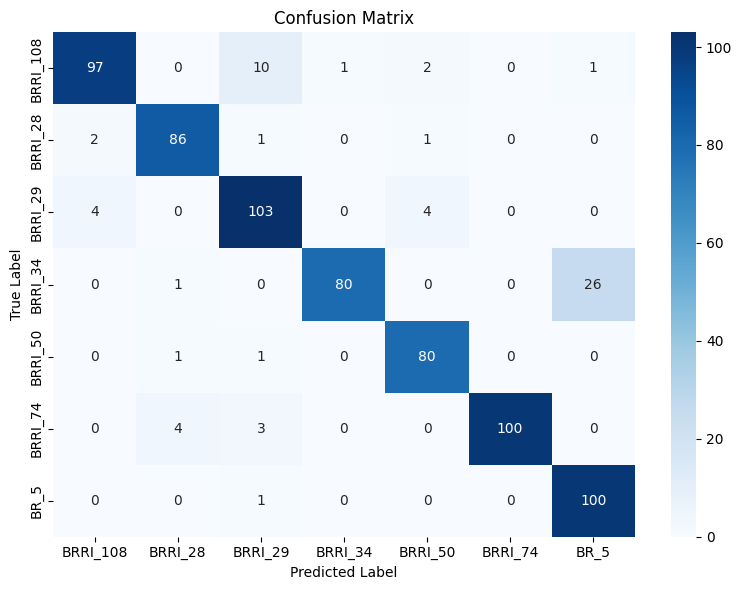

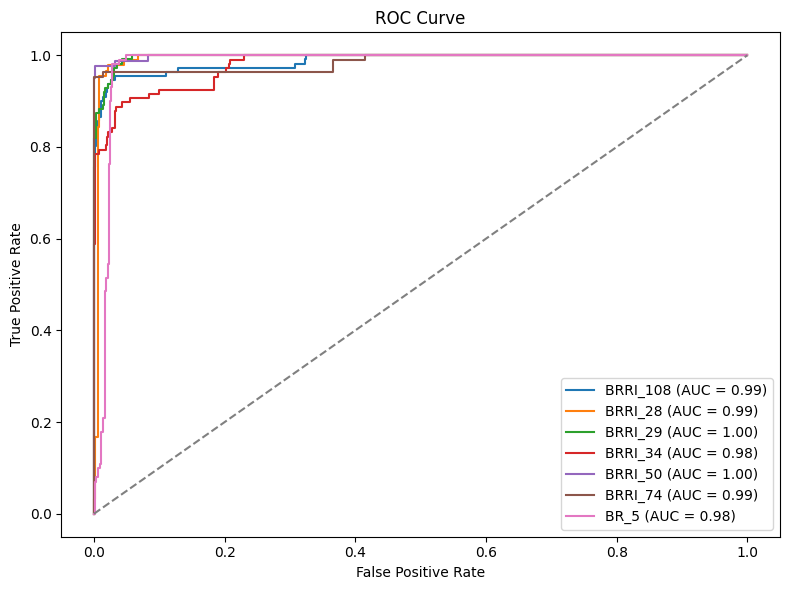

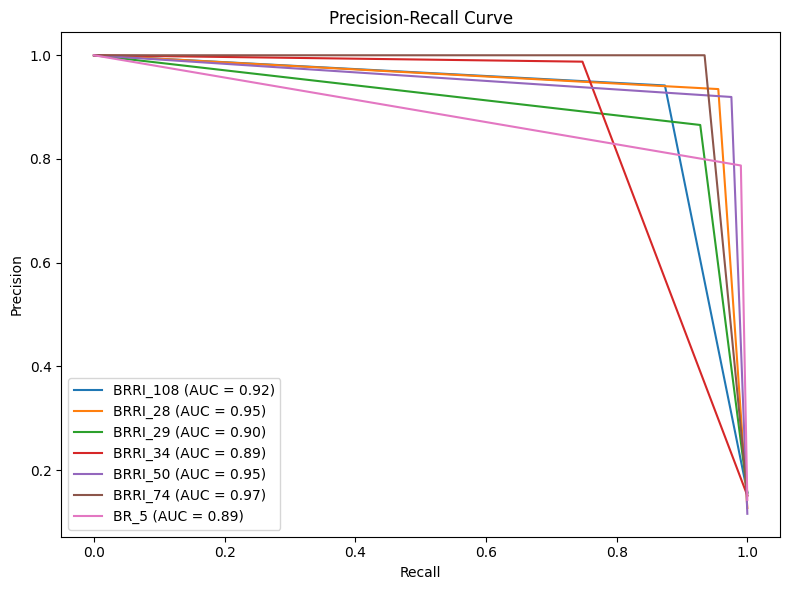

In [48]:
metrics3=evaluate_model(model3, val_loader, class_names, loader_name="Validation")


Evaluating model with Testing loader.

Overall Accuracy: 93.14%
Overall Error Rate: 6.86%
F1-Score (Macro-Averaged): 93.06%
F1-Score (Weighted): 93.15%
Matthews Correlation Coefficient (MCC): 92.07%
Cohen’s Kappa Score: 91.99%
Top-1 Accuracy (%): 93.14%
Top-5 Accuracy (%): 99.73%

Average Inference Time per Image: 0.166216 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          96.36       90.60         93.39            99.35
 BRRI_28          95.00       95.00         95.00            99.01
 BRRI_29          85.29       94.57         89.69            97.65
 BRRI_34          96.74       81.65         88.56            99.52
 BRRI_50          99.06       97.22         98.13            99.84
 BRRI_74          96.63       94.51         95.56            99.53
    BR_5          83.64      100.00         91.09            97.17

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_28

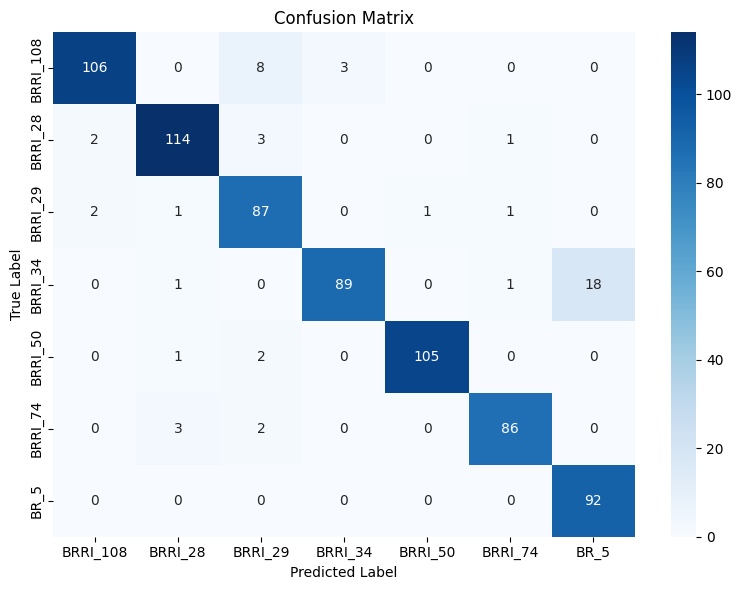

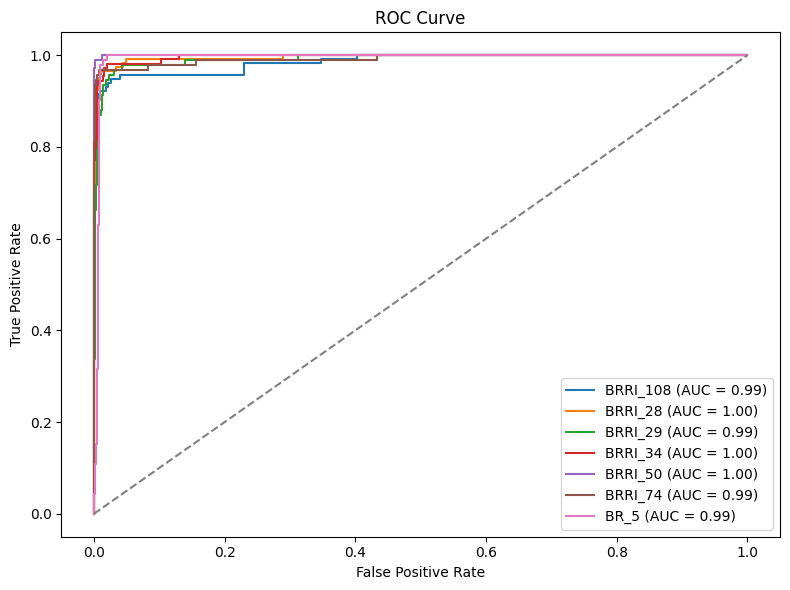

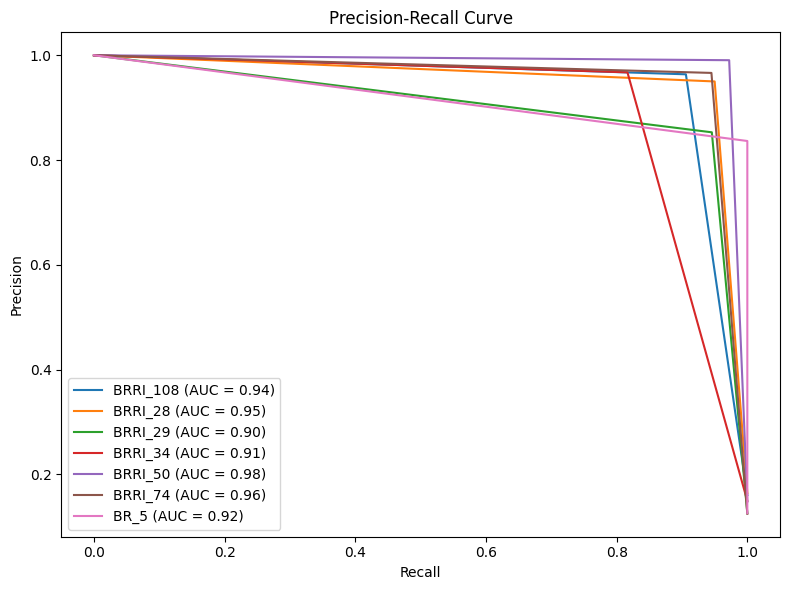

In [49]:
metrics3=evaluate_model(model3, test_loader, class_names, loader_name="Testing")

Merged 60 epochs of training.


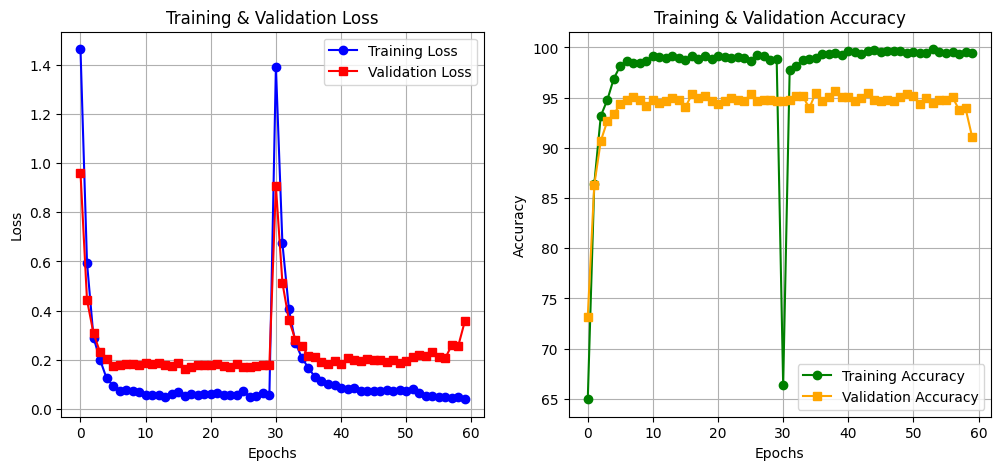

In [50]:
def merge_histories_and_plot(history1, history2, history3):
    """
    Merges three training history dictionaries and plots the combined training and validation curves.

    Args:
        history1, history2, history3: Dictionaries with keys "train_loss", "train_acc", "val_loss", "val_acc"
    """
    merged_history = {
        "train_loss": history1["train_loss"] + history2["train_loss"] + history3["train_loss"],
        "train_acc": history1["train_acc"] + history2["train_acc"] + history3["train_acc"],
        "val_loss": history1["val_loss"] + history2["val_loss"] + history3["val_loss"],
        "val_acc": history1["val_acc"] + history2["val_acc"] + history3["val_acc"]
    }

    print(f"Merged {len(history1['train_loss']) + len(history2['train_loss']) + len(history3['train_loss'])} epochs of training.")
    plotting(merged_history)
    return merged_history

final_history = merge_histories_and_plot(history1, history2, history3)